In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime

In [2]:
%run -i "D:/crs/src/NOPP_Utilities/storm_coords.py"
%run -i "D:/crs/src/NOPP_Utilities/scat_stats.py"

In [3]:
# Target date
start_date = np.datetime64('2019-09-03 00:00:00')
end_date = np.datetime64('2019-09-07 00:00:00')
tol = np.timedelta64(14, 'm') # not used

In [4]:
# Pamlico Sound model results
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/dorian_coupled11/PAM/dorian_his.ncml'
dsm = xr.open_dataset(url)
latm = dsm.lat_rho.values
lonm = dsm.lon_rho.values
time_all = dsm.ocean_time.values
idxms = int( np.where(time_all >= start_date)[0][0] )
idxme = int( np.where(time_all <= end_date)[0][-1] )
timem = time_all[idxms:idxme]
mask_rho = dsm.mask_rho.values
wd_mask_rho = dsm.wetdry_mask_rho[19,:,:].values
print(np.shape(wd_mask_rho))

(857, 1067)


In [5]:
# Data directory for observations downloaded using the Flood Event Viewer https://stn.wim.usgs.gov/fev/#2019Dorian
data_dir = 'D:/crs/docs/papers/2023_Warner_Dorian_paper/WL_Waves_data/'
# List of stations

# Stations will plot in roughly geographic locations
sta_list = ['NCCRV00003', 'NCBEA11728','NCHYD00001',
            'NCCAR12328', 'NCPAM13231'] #Hatteras here

url_list = ['NCCRV00003_stormtide_unfiltered.nc',  
            'NCBEA11728_stormtide_unfiltered.nc',
            'NCHYD00001_stormtide_unfiltered.nc',
            'NCCAR12328_stormtide_unfiltered.nc',
            'NCPAM13231_stormtide_unfiltered.nc']          
print(sta_list)
print(url_list)

['NCCRV00003', 'NCBEA11728', 'NCHYD00001', 'NCCAR12328', 'NCPAM13231']
['NCCRV00003_stormtide_unfiltered.nc', 'NCBEA11728_stormtide_unfiltered.nc', 'NCHYD00001_stormtide_unfiltered.nc', 'NCCAR12328_stormtide_unfiltered.nc', 'NCPAM13231_stormtide_unfiltered.nc']


         wl                time
0     0.222 2019-09-02 00:00:00
1     0.215 2019-09-02 00:06:00
2     0.224 2019-09-02 00:12:00
3     0.233 2019-09-02 00:18:00
4     0.236 2019-09-02 00:24:00
...     ...                 ...
1915  0.412 2019-09-09 23:30:00
1916  0.414 2019-09-09 23:36:00
1917  0.402 2019-09-09 23:42:00
1918  0.390 2019-09-09 23:48:00
1919  0.375 2019-09-09 23:54:00

[1920 rows x 2 columns]

 Hatteras 8654467 sensor_elev: -10
35.208, -75.705
model shape:  (857, 1067)
nlat, nlon:  (857, 1067)
ilatm, ilonm: 157 784
elev -10 , model depth:  0.8526758114514932  distance apart: 0.22540953636339411
time_threshold:  324.0
shape of obs.: (960,) (960,) (96,) (96,)
adding  0.0  to model output
Shape(wlm), wmli, wloi: (96,) (96,) (96,)
N: 96
Nnan: 0
RMSE: 0.245
rho: 0.839
Bias: -0.149
NRMSE: 0.564
HH: 0.732
Bias: -0.149
RMSE: 0.245
NRMSE: 0.564
rho : 0.839

 NCCRV00003 sensor_elev: 0.0762
34.936, -76.811
sample_interval:  30.0 smoothing over:  21.0
model shape:  (857, 1067)
nlat, n

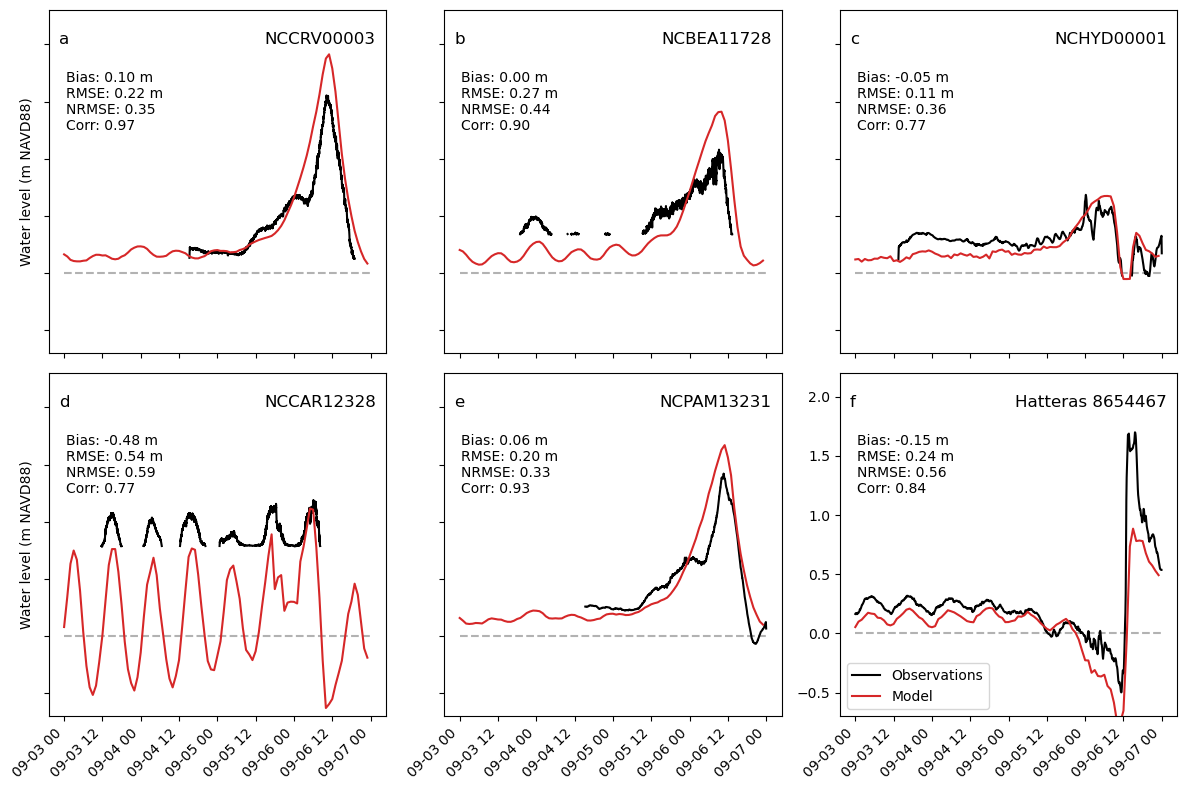

In [6]:
# Correction from model datum (MSL = 0.32) to WL datum (NAVD88 = 0.39) at Hattaras
# NAVD88 = MSL + zcorr (m)
#zcorr = -0.07 
zcorr = 0.

# define plot start and end time
# Define start and end time
pstart_time = datetime.datetime(2019, 9, 3, 0, 0)
pend_time = datetime.datetime(2019, 9, 7, 0, 0)
abcde = ['a','b','c','d','e','f']

# set up figure
# Create an array with 12-hour increments
x_ticks = np.arange(start_date, end_date+np.timedelta64(12, 'h'), np.timedelta64(12, 'h'))

# Format the tick labels (e.g., 'MM-DD HH:MM' format)
x_labels = [pd.Timestamp(x).strftime('%m-%d %H') for x in x_ticks]

fig, axs = plt.subplots( 2, 3, sharex=True, sharey=False, figsize=( 12, 8 ) )
# axes will be number in column, row order
axf = axs.flatten()

# Load the Cape Hatteras NOAA data (downloaded on 11/9/2024 in metric units with NAVD88 datum
# Read CSV, combine 'Date' and 'Time (GMT)' columns into a datetime column
df = pd.read_csv(data_dir+'CO-OPS_8654467_wl.csv')
# Combine 'Date' and 'Time (GMT)' columns into a single datetime column
df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'], errors='coerce')

# Drop columns 3 and 4, and rename columns as needed
df = df.drop(columns=['Date','Time (GMT)','Predicted (m)', 'Preliminary (m)'])
df = df.rename(columns={'time': 'time', 'Verified (m)': 'wl'})

# Ensure 'wl' column is of type float
df['wl'] = pd.to_numeric(df['wl'], errors='coerce')

# Display the cleaned DataFrame
print(df)

lato = 35.+12.5/60.
lono = 	-(75+42.3/60.)
sensor_elev =  -10 
sta_name = 'Hatteras 8654467'
print('\n',sta_name, 'sensor_elev:', sensor_elev)
print('{:.3f}, {:.3f}'.format(lato, lono))
time_all = df['time'].values
time_diffs = df['time'].diff()
time_diffs_seconds = df['time'].diff().dt.total_seconds()
# Print the first five elements as float values
# print('Time differences in seconds:', time_diffs_seconds[:5].values)
sample_interval = np.round( np.nanmin( time_diffs_seconds ), 3 )

# Get indices for observation start/end times
idxos = int( np.where(time_all >= start_date)[0][0] )
idxoe = int( np.where(time_all <= end_date)[0][-1] )
timeo = time_all[idxos:idxoe]

# Get WL time series
wlo = np.squeeze( df['wl'][idxos:idxoe].values )

# Find closest model grid point
# Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
model_shape = np.shape( lonm )
print('model shape: ',model_shape)
print('nlat, nlon: ',np.shape(mask_rho))

# Find the indices of the nearest lat/lon
dist = haversine( (lonm*wd_mask_rho), (latm*wd_mask_rho) , lono, lato )
ilatm, ilonm = np.argwhere( dist == np.min(dist) ).squeeze()  
print('ilatm, ilonm:', ilatm, ilonm )
# Get the water depth
hm  = dsm.h[ilatm, ilonm].values
print('elev',sensor_elev,', model depth: ',hm,' distance apart:',dist[ilatm,ilonm])

# Find the observation times that correspond with model time
time_threshold = (.9*sample_interval)
print('time_threshold: ', time_threshold )
# Empty arrays to hold indices into each time series
oindex_list = []
mindex_list = []

# Loop through each time in dataset_time1
for ij, mt in enumerate(timem):
    # Calculate absolute time differences between the current model time and all times in obs. time
    time_diffs = np.abs(timeo - mt)
    
    # Find the nearest index within the threshold
    idx = np.argmin(time_diffs)

    # Check if the nearest time difference is within the threshold
    if time_diffs[idx].astype(float) <= time_threshold.astype(float):
        # Append to the index lists
        oindex_list.append(idx)
        mindex_list.append(ij)

# Observation times are a subset (i indicates interpolated times)
timeoi = timeo[oindex_list]
wloi = wlo[oindex_list]
# Model times usually include all hourly times
timemi = timem[mindex_list]
# Get model data for specified times, lat, and lons
wlm = dsm.zeta[idxms:idxme, ilatm, ilonm].values
wlmi = wlm[mindex_list]

print('shape of obs.:',np.shape(timeo), np.shape(wlo), np.shape(timeoi), np.shape( wloi))
# Adjust model data accoriding to datums, assuming model is MSL and obs. are NAVD88.
# zcorr = MSL - NAVD88 = 0.32 - 0.39 = -0.07
print('adding ',zcorr,' to model output')
wlm = wlm + zcorr
wlmi = wlmi + zcorr
print('Shape(wlm), wmli, wloi:', np.shape(wlm), np.shape(wlmi), np.shape(wloi))

# Calclulate scatter stats
a, s = scat_stats_string( wlmi, wloi, sep_lines=True )
txt = 'Bias: {0:.3f}\nRMSE: {1:.3f}\nNRMSE: {2:.3f}\nrho : {3:.3f}' \
    .format( a[4],a[2],a[5],a[3])
print(s)
print(txt)

i = 5 # put Hatteras on lower right
axf[i].text(.97, .9, sta_name, fontsize=12, ha='right', transform=axf[i].transAxes )
axf[i].plot([pstart_time, pend_time],[0., 0.], '--', c='gray', alpha=.6)
axf[i].plot(timeo, wlo, '-k', label='Observations')
axf[i].plot(timem, wlm, '-', c='tab:red', label='Model')
a, s = scat_stats_string( wlmi, wloi, sep_lines=True )
txt = 'Bias: {0:.2f} m\nRMSE: {1:.2f} m\nNRMSE: {2:.2f}\nCorr: {3:.2f}' \
    .format( a[4],a[2],a[5],a[3])
axf[i].text(.05, .65, txt, fontsize=10, transform=axf[i].transAxes )
axf[i].text(.03, .9, abcde[i], fontsize=12, transform=axf[i].transAxes )
axf[i].set_ylim((-.7,2.2))
axf[i].legend(loc='lower left')
axf[i].set_xticks( x_ticks )
axf[i].set_xticklabels(x_labels, rotation=45, ha="right")


time_diffs_seconds


for i, url in enumerate( url_list ):

    # Get information
    ds = xr.open_dataset( data_dir + url )
    lato = ds['latitude'].values
    lono = ds['longitude'].values
    sensor_elev = ds.attrs['sensor_orifice_elevation_at_deployment_time']
    print('\n',sta_list[i], 'sensor_elev:', sensor_elev)
    print('{:.3f}, {:.3f}'.format(lato, lono))
    time_all = ds['time'].values
    time_diffs = ds['time'].diff(dim='time')
    time_diffs_seconds = time_diffs.dt.total_seconds()
    # Print the first five elements as float values
    # print('Time differences in seconds:', time_diffs_seconds[:5].values)
    sample_interval = np.round( np.median( time_diffs_seconds ), 3 )
    
    # Get indices for observation start/end times
    idxos = int( np.where(time_all >= start_date)[0][0] )
    idxoe = int( np.where(time_all <= end_date)[0][-1] )
    timeo = time_all[idxos:idxoe]
    
    # Get WL time series
    wlufo = np.squeeze( ds.unfiltered_water_surface_height_above_reference_datum[idxos:idxoe].values )
    wlo = np.squeeze( ds.water_surface_height_above_reference_datum[idxos:idxoe].values )
    # for some of the obs, the first point looks weird
    if i==3 or i==4 or i==5:
        wlufo[0]=np.nan
        wlo[0]=np.nan  
    
    # Smooth unfiltered observations over 10 minutes
    # TODO - How best to filter? Esp. for ts with missing values or that go dry
    # How many points?
    npts = 1.+600./sample_interval
    print('sample_interval: ', sample_interval, 'smoothing over: ',npts)
    wghts = np.ones(int(npts)) / npts  # Equal weights for averaging
    # Apply the running average
    wlufos = np.convolve(wlufo, wghts, mode='same')
    # Remove points below the sensor elevation plus some arbitrary fudge factor
    sla = sensor_elev+0.05
    wlufo[wlufo<=sla]=sla
    wlufos[wlufos<=sla]=np.nan

    # Find closest model grid point
    # Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
    model_shape = np.shape( lonm )
    print('model shape: ',model_shape)
    print('nlat, nlon: ',np.shape(mask_rho))
    
    # Find the indices of the nearest lat/lon
    dist = haversine( (lonm*wd_mask_rho), (latm*wd_mask_rho) , lono, lato )
    ilatm, ilonm = np.argwhere( dist == np.min(dist) ).squeeze()  
    print('ilatm, ilonm:', ilatm, ilonm )
    # Get the water depth
    hm  = dsm.h[ilatm, ilonm].values
    print('elev',sensor_elev,', model depth: ',hm,' distance apart:',dist[ilatm,ilonm])

    # Find the observation times that correspond with model time
    time_threshold = (.9*sample_interval)
    # Empty arrays to hold indices into each time series
    oindex_list = []
    mindex_list = []
    
    # Loop through each time in dataset_time1
    for ij, mt in enumerate(timem):
        # Calculate absolute time differences between the current model time and all times in obs. time
        time_diffs = np.abs(timeo - mt)
        
        # Find the nearest index within the threshold
        idx = np.argmin(time_diffs)
        
        # Check if the nearest time difference is within the threshold
        if time_diffs[idx].astype(float) <= time_threshold.astype(float):
            # Append to the index lists
            oindex_list.append(idx)
            mindex_list.append(ij)
    
    # Observation times are a subset (i indicates interpolated times)
    timeoi = timeo[oindex_list]
    wlufosi = wlufos[oindex_list]
    # Model times usually include all hourly times
    timemi = timem[mindex_list]
    # Get model data for specified times, lat, and lons
    wlm = dsm.zeta[idxms:idxme, ilatm, ilonm].values
    wlmi = wlm[mindex_list]

    print('shape of obs.:',np.shape(timeo), np.shape(wlufos), np.shape(timeoi), np.shape( wlufosi))
    # Adjust model data accoriding to datums, assuming model is MSL and obs. are NAVD88.
    # zcorr = MSL - NAVD88 = 0.32 - 0.39 = -0.07
    print('adding ',zcorr,' to model output')
    wlm = wlm + zcorr
    wlmi = wlmi + zcorr
    print('Shape(wlm), wmli, wlufosi:', np.shape(wlm), np.shape(wlmi), np.shape(wlufosi))

    # Calclulate scatter stats
    a, s = scat_stats_string( wlmi, wlufosi, sep_lines=True )
    txt = 'Bias: {0:.3f}\nRMSE: {1:.3f}\nNRMSE: {2:.3f}\nrho : {3:.3f}' \
        .format( a[4],a[2],a[5],a[3])
    print(s)
    print(txt)
    
    if i != 5:
        axf[i].text(.97, .9, sta_list[i], fontsize=12, ha='right', transform=axf[i].transAxes )
        axf[i].plot([pstart_time, pend_time],[0., 0.], '--', c='gray', alpha=.6)
        axf[i].plot(timeo, wlufos, '-k', label='Observations')
        axf[i].plot(timem, wlm, '-', c='tab:red', label='Model')
        a, s = scat_stats_string( wlmi, wlufosi, sep_lines=True )
        txt = 'Bias: {0:.2f} m\nRMSE: {1:.2f} m\nNRMSE: {2:.2f}\nCorr: {3:.2f}' \
            .format( a[4],a[2],a[5],a[3])
        axf[i].text(.05, .65, txt, fontsize=10, transform=axf[i].transAxes )
        axf[i].text(.03, .9, abcde[i], fontsize=12, transform=axf[i].transAxes )
        axf[i].set_ylim((-.7,2.3))
        axf[i].set_yticklabels([])
    if i==0:
        axf[i].set_ylabel('Water level (m NAVD88)')
    if i==3:
        axf[i].set_ylabel('Water level (m NAVD88)')
        axf[i].set_xticks( x_ticks )
        axf[i].set_xticklabels(x_labels, rotation=45, ha="right")
    if i==4:
        axf[i].set_xticks( x_ticks )
        axf[i].set_xticklabels(x_labels, rotation=45, ha="right")
    if i==5:
        axf[i].set_xticks( x_ticks )
        axf[i].set_xticklabels(x_labels, rotation=45, ha="right")
        
plt.tight_layout()
plt.savefig(data_dir+'dorian_wl_stats_fig6.png', bbox_inches='tight', dpi=200)